In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm #progress bar
import matplotlib.pyplot as plt

##Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#set work path
project_path = "/content/drive/My Drive/DATASCI210/capstone_project"
os.listdir(project_path)

Mounted at /content/drive


['Planning Documents',
 'Recycling Guide Resources.gdoc',
 'palm_desert.txt',
 'cook_county_recycling_instruc.txt',
 'Notebooks',
 'Presentations',
 'image_data',
 'ReferenceSentences.gsheet',
 'llama_result_s1.pkl',
 'llama_result_s2.pkl',
 'llama_result_s3.pkl',
 'cook_county_recycling_instruc.gdoc',
 'monkey.png',
 'Title1.png',
 'Title2.png',
 'recyclingImage1.png',
 'recyclingImage3.png',
 'recyclingImage2.png',
 'cook_county_recycling_instruc_updated.txt',
 'cook_county_recycling_instruc_updated3.txt',
 'cook_county_recycling_instruc_new.txt',
 'results',
 'RAG_files',
 'RecycleRight.gsite',
 'finetuned_llava']

cardboard_box


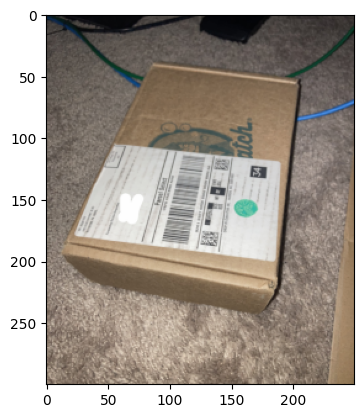

In [3]:
images = np.load(project_path+'/image_data/test_x_data.npy')
labels = np.load(project_path+'/image_data/test_y_data.npy', allow_pickle=True).flatten()

#check one
print(labels[0])
plt.imshow(images[0])

##Setup: Llama vision instruct

In [4]:
!pip install --upgrade transformers
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|   

In [5]:
import requests
import torch
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

In [16]:
def get_cv_response(img, instruction, num_new_token):

  image = img

  messages = [
      {"role": "user", "content": [
          {"type": "image"},
          {"type": "text", "text": instruction}
      ]}
  ]
  input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

  inputs = processor(
      image,
      input_text,
      add_special_tokens=False,
      return_tensors="pt"
  ).to(model.device)

  output = model.generate(**inputs, max_new_tokens=num_new_token)
  # response_text = processor.decode(output[0])
  response_text = processor.decode(output[0]).split("<|start_header_id|>assistant<|end_header_id|>\n\n")[1].split("<|eot_id|>")[0].replace(".","").replace(" ","_").lower()

  return response_text


##Classification (prompt1)

In [8]:
prompt_1 = """
What is the waste object in this image, output just the name.
"""

In [17]:
predict_cv_1= []

for i in tqdm(range(images.shape[0])):
  predict_cv_1.append(get_cv_response(images[i], prompt_1, 50))

100%|██████████| 84/84 [00:40<00:00,  2.08it/s]


In [11]:
np.unique(labels)

array(['cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [18]:
np.unique(predict_cv_1)

array(['**food_packaging**', '**object:**_a_can_of_soda',
       '**object_identification**\n\n*_the_object_in_the_image_is_identified_as_a_**box**',
       '**waste_object:**\n\n*_starbucks_cup',
       '**waste_object:**_\n*_computer_tower', 'bottle', 'box',
       'bubble_wrap', 'can', 'candle', 'canned_food', 'canned_paste',
       'cans', 'cardboard', 'cardboard_box', 'chair', 'computer_monitor',
       'cup', 'glass', 'glass_bottle', 'jar', 'jug', 'keyboard',
       'milk_jug', 'paper_cup', 'plastic_bag', 'plastic_bags',
       'plastic_bottle', 'plastic_container', 'plastic_cup',
       'plastic_food_container', 'plastic_jug', 'plastic_milk_container',
       'sneaker', 'starbucks_cup', 'toilet_paper', 'vacuum',
       'washing_machine', 'wegmans_memphis_style_bbq_sauce_bottle'],
      dtype='<U79')

In [19]:
reps = {'**food_packaging**': 'INCORRECT',
        '**object:**_a_can_of_soda': 'metal_beverage_can',
       '**object_identification**\n\n*_the_object_in_the_image_is_identified_as_a_**box**': 'cardboard_box',
       '**waste_object:**\n\n*_starbucks_cup': 'paper_cup',
       '**waste_object:**_\n*_computer_tower': 'INCORRECT',
        'bottle': 'INCORRECT',
        'box': 'cardboard_box',
       'bubble_wrap': 'INCORRECT',
        'can': 'INCORRECT',
        'candle': 'INCORRECT',
        'canned_food': 'metal_food_can',
        'canned_paste': 'metal_food_can',
       'cans': 'INCORRECT',
        'cardboard': 'cardboard_box',
        'chair': 'INCORRECT',
        'computer_monitor': 'INCORRECT',
       'cup': 'INCORRECT',
        'glass': 'glass_bottle',
        'jar': 'INCORRECT',
        'jug': 'plastic_jug',
        'keyboard': 'INCORRECT',
       'milk_jug': 'plastic_jug',
        'plastic_bags': 'plastic_bag',
       'plastic_container': 'plastic_food_container',
        'plastic_milk_container': 'plastic_jug',
       'sneaker': 'INCORRECT',
        'starbucks_cup': 'paper_cup',
        'toilet_paper': 'INCORRECT',
        'vacuum': 'INCORRECT',
       'washing_machine': 'INCORRECT',
        'wegmans_memphis_style_bbq_sauce_bottle': 'glass_bottle'}

predict_result=[reps.get(x,x) for x in predict_cv_1]

# predict_cv_fixed[predict_cv_fixed=='metal_food_can']='aluminum_can'
# predict_cv_fixed[predict_cv_fixed=='paper_box']='boxes'
# predict_cv_fixed[predict_cv_fixed=='plastic_bag']='others'
# predict_cv_fixed[predict_cv_fixed=='Others']='others'
# predict_cv_fixed[predict_cv_fixed=='battery']='others'

np.unique(predict_result)

array(['INCORRECT', 'cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_food_container', 'plastic_jug'],
      dtype='<U22')

In [20]:
accuracy_count = 0

for i in range(len(predict_result)):
  if predict_result[i]!="INCORRECT":
    if predict_result[i]==labels[i]:
      accuracy_count+=1

print("Accuracy of this prompt: ", accuracy_count/len(predict_result))

Accuracy of this prompt:  0.5595238095238095


##Classification (prompt2)

In [26]:
prompt_2 = """
What is this waste item, tell me only what is it made of and it's name
"""

In [27]:
predict_cv_2= []

for i in tqdm(range(images.shape[0])):
  predict_cv_2.append(get_cv_response(images[i], prompt_2, 20))

100%|██████████| 84/84 [01:40<00:00,  1.19s/it]


In [23]:
np.unique(labels)

array(['cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [28]:
np.unique(predict_cv_2)

array(['**composition:**_aluminum\n**name:**_soda_can',
       '**composition_and_name**\n\n*_made_of:_**cardboard**\n*_name:_**amazon_prime_box',
       '**composition_and_name_of_the_waste_item**\n\n*_the_waste_item_is_made_of_aluminum_and_plastic\n',
       '**description_of_a_waste_item**\n\n*_**material:**_aluminum\n*_**name:**_soda_can',
       '**material_composition:**\n*_made_of_plastic\n\n**name:**_plastic_cup',
       '**material_composition:**\n*_made_of_polypropylene_(pp)_plastic\n\n**name:**\n',
       '**material_composition:**\n•_tinplate\n•_lacquer_coating\n\n**name:**\ncanned',
       '**material_composition:**_\n*_made_of_paper_and_cardboard\n\n**name:**_\n*_cardboard_box',
       '**material_composition:**_\n*_made_of_polyethylene_terephthalate_(pet)\n\n**common',
       '**material_composition:**_cardboard\n**name:**_shipping_box',
       '**material_composition:**_polyethylene\n**name:**_plastic_bag',
       '**milk_jug**\n\n*_composition:_plastic\n*_name:_polyeth

In [29]:
reps = {'**composition:**_aluminum\n**name:**_soda_can': 'metal_beverage_can',
       '**composition_and_name**\n\n*_made_of:_**cardboard**\n*_name:_**amazon_prime_box': 'cardboard_box',
       '**composition_and_name_of_the_waste_item**\n\n*_the_waste_item_is_made_of_aluminum_and_plastic\n': 'INCORRECT',
       '**description_of_a_waste_item**\n\n*_**material:**_aluminum\n*_**name:**_soda_can': 'metal_beverage_can',
       '**material_composition:**\n*_made_of_plastic\n\n**name:**_plastic_cup': 'plastic_cup',
       '**material_composition:**\n*_made_of_polypropylene_(pp)_plastic\n\n**name:**\n': 'INCORRECT',
       '**material_composition:**\n•_tinplate\n•_lacquer_coating\n\n**name:**\ncanned': 'metal_food_can',
       '**material_composition:**_\n*_made_of_paper_and_cardboard\n\n**name:**_\n*_cardboard_box': 'cardboard_box',
       '**material_composition:**_\n*_made_of_polyethylene_terephthalate_(pet)\n\n**common': 'INCORRECT',
       '**material_composition:**_cardboard\n**name:**_shipping_box': 'cardboard_box',
       '**material_composition:**_polyethylene\n**name:**_plastic_bag': 'plastic_bag',
       '**milk_jug**\n\n*_composition:_plastic\n*_name:_polyethylene_terephthalate': 'plastic_jug',
       '**milk_jug_composition_and_name**\n\n*_made_of_**hdpe_(high-density_polyethylene': 'plastic_jug',
       '**milk_jug_description**\n\n*_composition:_plastic\n*_name:_half-gallon_milk_jug': 'plastic_jug',
       '**product_description**\n\n*_made_from:_cardboard\n*_name:_ritz_crackers_box': 'cardboard_box',
       '**product_description**\n\n*_name:_ritz_crackers\n*_composition:_cracker_biscuits_made_from': 'cardboard_box',
       '**waste_item_details**\n\n*_material:_plastic\n*_name:_gallon_jug':'plastic_jug',
       'the_item_is_a_**plastic_bag**_made_of_**polyethylene**': 'plastic_bag',
       'the_waste_item_in_the_image_is_a_glass_jar_made_of_glass_and_has_a_plastic_lid': 'glass_bottle',
       'the_waste_item_is_a_can,_made_of_aluminum_and_tin,_and_is_known_as_a_soda_can': 'metal_beverage_can',
       'the_waste_item_is_a_can_of_sparkling_water,_made_of_aluminum': 'metal_beverage_can',
       'the_waste_item_is_a_glass_bottle_made_of_**glass**': 'glass_bottle',
       'the_waste_item_is_a_glass_bottle_made_of_**silicate_glass**': 'glass_bottle',
       'the_waste_item_is_a_glass_bottle_made_of_glass_and_plastic_the_name_of_the_product_is_"': 'glass_bottle',
       'the_waste_item_is_a_paper_cup,_made_of_paper': 'paper_cup',
       'the_waste_item_is_a_plastic_bottle_made_of_**polyethylene_terephthalate_(pet)**': 'plastic_bottle',
       'the_waste_item_is_a_tin_can,_made_of_tinplate': 'metal_food_can',
       'the_waste_item_is_a_tin_can,_which_is_made_of_tinplate': 'metal_food_can',
       'the_waste_item_is_a_tin_can_made_of_tinplate,_and_its_name_is_contadina_crush': 'metal_food_can',
       'the_waste_item_is_made_of_**plastic**,_and_its_name_is_**vacuum_packing**': 'INCORRECT',
       'the_waste_item_is_made_of_**plastic**_and_is_called_a_**starbucks_cup**': 'plastic_cup',
       'the_waste_item_is_made_of_**polyethylene**_and_is_called_a_**polyethylene_bag**': 'plastic_bag',
       'this_is_a_box_of_ritz_crackers,_made_of_paper_and_plastic': 'cardboard_box',
       'this_is_a_plastic_bag_filled_with_silica_gel_packets,_which_are_made_of_silica_gel': 'plastic_bag',
       'this_waste_item_is_a_**polypropylene_cup**,_also_known_as_a_**maruchan_instant': 'plastic_cup',
       'this_waste_item_is_a_**styrofoam_cup**,_made_of_**polystyrene**': 'styrofoam_cup',
       'this_waste_item_is_a_can_made_of_aluminum_and_is_called_a_polar_seltzer_can': 'metal_beverage_can',
       'this_waste_item_is_a_can_made_of_aluminum_and_is_called_a_soda_can': 'metal_beverage_can',
       'this_waste_item_is_a_can_made_of_aluminum_and_steel,_and_it\'s_name_is_a_"pol': 'metal_beverage_can',
       'this_waste_item_is_a_can_made_of_aluminum_and_steel,_and_its_name_is_a_"polar': 'metal_beverage_can',
       'this_waste_item_is_a_can_made_of_tinplate,_also_known_as_tin,_and_its_name_is': 'metal_food_can',
       'this_waste_item_is_a_can_of_polar_seltzer,_made_of_aluminum_and_plastic': 'metal_beverage_can',
       'this_waste_item_is_a_glass_bottle,_made_of_glass': 'glass_bottle',
       'this_waste_item_is_a_metal_can_made_of_aluminum_and_steel,_and_its_name_is_an_a&w': 'metal_food_can',
       'this_waste_item_is_a_paper_cup,_made_of_paper':'paper_cup',
       'this_waste_item_is_a_pet_(polyethylene_terephthalate)_plastic_bottle,_specifically_a': 'plastic_bottle',
       'this_waste_item_is_a_plastic_bottle_made_of_polyethylene_terephthalate_(pet)': 'plastic_bottle',
       'this_waste_item_is_a_polystyrene_cup,_commonly_referred_to_as_a_starbucks_cup': 'plastic_cup',
       'this_waste_item_is_a_styrofoam_cup,_made_of_expanded_polystyrene_(eps': 'styrofoam_cup',
       'this_waste_item_is_made_of_**aluminum**_and_is_called_a_**canned_food_container**': 'metal_food_can',
       'this_waste_item_is_made_of_**cardboard**_and_is_called_a_**package**': 'cardboard_box',
       'this_waste_item_is_made_of_**glass**,_and_its_name_is_a_**glass_bottle**': 'glass_bottle',
       'this_waste_item_is_made_of_**high-density_polyethylene_(hdpe)**_and_is_called_a': 'INCORRECT',
       'this_waste_item_is_made_of_**high-density_polyethylene_(hdpe)**_and_is_commonly_known': 'INCORRECT',
       'this_waste_item_is_made_of_**high-density_polyethylene_(hdpe)**_and_is_commonly_referred': 'INCORRECT',
       'this_waste_item_is_made_of_**high-density_polyethylene_(hdpe)**_and_is_known_as': 'INCORRECT',
       "this_waste_item_is_made_of_**plastic**,_and_it's_called_a_**plastic_food_container": 'plastic_food_container',
       'this_waste_item_is_made_of_**plastic**_and_is_called_a_**cup_noodle**': 'styrofoam_cup',
       'this_waste_item_is_made_of_**plastic**_and_is_called_a_**jug**': 'plastic_jug',
       'this_waste_item_is_made_of_**plastic**_and_is_called_a_**plastic_punnet**': 'INCORRECT',
       'this_waste_item_is_made_of_**plastic**_and_is_called_a_**vacuum-sealed_bag': 'plastic_bag',
       'this_waste_item_is_made_of_**plastic**_and_its_name_is_**cup_noodle**': 'styrofoam_cup',
       'this_waste_item_is_made_of_**polyethylene**_and_is_called_a_**plastic_bag**': 'plastic_bag',
       'this_waste_item_is_made_of_**polyethylene**_and_is_commonly_known_as_a_**plastic_bag': 'plastic_bag',
       'this_waste_item_is_made_of_**polyethylene_terephthalate_(pet)**_and_is_a': 'INCORRECT',
       'this_waste_item_is_made_of_**polyethylene_terephthalate_(pet)**_and_is_called': 'INCORRECT',
       'this_waste_item_is_made_of_**polyethylene_terephthalate_(pet)**_and_is_commonly': 'INCORRECT',
       'this_waste_item_is_made_of_**polypropylene**_and_is_a_**starbucks_cup**': 'plastic_cup',
       'this_waste_item_is_made_of_**pulp**_and_is_called_a_**berry_container**': 'plastic_food_container',
       'this_waste_item_is_made_of_**recycled_paperboard**,_and_its_name_is_an_**amazon_prime': 'cardboard_box',
       'this_waste_item_is_made_of_**tin**_and_is_called_a_**tin_can**': 'metal_food_can',
       'this_waste_item_is_made_of_aluminum_and_is_called_a_soda_can': 'metal_beverage_can',
       "this_waste_item_is_made_of_aluminum_and_steel,_and_it's_called_a_can": 'metal_beverage_can',
       'this_waste_item_is_made_of_cardboard_and_is_called_a_shipping_box': 'cardboard_box',
       'this_waste_item_is_made_of_metal_and_tin,_and_its_name_is_a_can': 'metal_food_can',
       'this_waste_item_is_made_of_paper_and_is_called_a_cardboard_box': 'cardboard_box',
       'this_waste_item_is_made_of_paper_and_is_called_a_starbucks_coffee_cup': 'paper_cup',
       'this_waste_item_is_made_of_paper_and_is_called_a_starbucks_cup': 'paper_cup',
       'this_waste_item_is_made_of_plastic_and_is_called_bubble_wrap': 'INCORRECT',
       'this_waste_item_is_made_of_tinplate,_also_known_as_tin-free_steel,_and_its_name_is': 'INCORRECT',
       'this_waste_item_is_made_of_vegetable-based_ingredients_and_is_called_ritz_crackers': 'cardboard_box'}

predict_result=[reps.get(x,x) for x in predict_cv_2]

np.unique(predict_result)

array(['INCORRECT', 'cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_food_container', 'plastic_jug',
       'styrofoam_cup'], dtype='<U22')

In [30]:
accuracy_count = 0

for i in range(len(predict_result)):
  if predict_result[i]!="INCORRECT":
    if predict_result[i]==labels[i]:
      accuracy_count+=1

print("Accuracy of this prompt: ", accuracy_count/len(predict_result))

Accuracy of this prompt:  0.7142857142857143


##Classification (prompt3)

In [35]:
prompt_3 = """
What is this waste item? Tell me the material it is made of and it's name in same phrase, ignore the brand.
"""

In [36]:
predict_cv_3= []

for i in tqdm(range(images.shape[0])):
  predict_cv_3.append(get_cv_response(images[i], prompt_3, 50))

100%|██████████| 84/84 [01:30<00:00,  1.08s/it]


In [33]:
np.unique(labels)

array(['cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [44]:
predict_cv_3 = [x.replace('the_waste_item_is_a_','').replace('this_waste_item_is_a_','').replace('**','').replace('a_','') for x in predict_cv_3]

In [45]:
np.unique(predict_cv_3)

array(['beverage_can_made_of_aluminum',
       "bubble_wrap_made_of_plastic,_and_it's_also_known_as_bubble_wrap",
       'can_made_of_aluminum',
       'can_made_of_aluminum,_lightweight,_corrosion-resistant_metal',
       'can_made_of_aluminum_and_is_beverage_can', 'cardboard_box',
       'cardboard_box,_made_of_cardboard',
       'cardboard_box,_made_of_corrugated_cardboard',
       'cardboard_box,_made_of_paper_material',
       'cardboard_box_it_is_made_of_corrugated_cardboard,_which_is_type_of_paper-based_material_that_is_composed_of_layers_of_paper_pulp_that_are_pressed_together_to_create_strong_and_rigid_sheet',
       'corrugated_cardboard_box', 'cracker_box_made_of_cardboard',
       'disposable_cup,_made_of_paper,_and_its_name_is_hot_beverage_cup',
       'disposable_cup_made_of_paper',
       'disposable_cup_made_of_polypropylene,_commonly_known_as_plastic_cup',
       'disposable_cup_made_of_styrofoam',
       'disposable_paper_cup,_made_of_paper',
       'disposable_plasti

In [48]:
reps = {'beverage_can_made_of_aluminum': 'metal_beverage_can',
       "bubble_wrap_made_of_plastic,_and_it's_also_known_as_bubble_wrap": 'INCORRECT',
       'can_made_of_aluminum': 'INCORRECT',
       'can_made_of_aluminum,_lightweight,_corrosion-resistant_metal': 'INCORRECT',
       'can_made_of_aluminum_and_is_beverage_can': 'metal_beverage_can',
       'cardboard_box,_made_of_cardboard': 'cardboard_box',
       'cardboard_box,_made_of_corrugated_cardboard': 'cardboard_box',
       'cardboard_box,_made_of_paper_material': 'cardboard_box',
       'cardboard_box_it_is_made_of_corrugated_cardboard,_which_is_type_of_paper-based_material_that_is_composed_of_layers_of_paper_pulp_that_are_pressed_together_to_create_strong_and_rigid_sheet': 'cardboard_box',
       'corrugated_cardboard_box': 'cardboard_box',
        'cracker_box_made_of_cardboard': 'cardboard_box',
       'disposable_cup,_made_of_paper,_and_its_name_is_hot_beverage_cup': 'paper_cup',
       'disposable_cup_made_of_paper': 'paper_cup',
       'disposable_cup_made_of_polypropylene,_commonly_known_as_plastic_cup': 'plastic_cup',
       'disposable_cup_made_of_styrofoam': 'styrofoam_cup',
       'disposable_paper_cup,_made_of_paper': 'paper_cup',
       'disposable_plastic_cup,_made_of_polypropylene_and_polystyrene': 'plastic_cup',
       'food_packaging,_made_of_paper_and_cardboard': 'cardboard_box',
       'glass_bottle,_made_of_glass': 'glass_bottle',
        'glass_jar,_made_of_glass': 'glass_bottle',
       'material_and_name_of_the_waste_item\n\nthe_waste_item_is_made_of_tin_and_is_referred_to_as_tin_can': 'INCORRECT',
       'metal_can': 'INCORRECT',
        'metal_can,_made_of_aluminum': 'INCORRECT',
       'paper_cup,_made_of_paper': 'paper_cup',
       'plastic_bag_made_of_polyethylene': 'plastic_bag',
       'plastic_bag_made_of_polyethylene,_commonly_referred_to_as_polyethylene_bag': 'plastic_bag',
       'plastic_bag_made_of_polyethylene,_type_of_plastic_commonly_used_for_packaging_and_wrapping_items': 'plastic_bag',
       'plastic_bag_made_of_polyethylene_terephthalate_(pet)_and_is_commonly_known_as_vacuum-seal_bag': 'plastic_bag',
       'plastic_bottle,_made_of_pet': 'plastic_bottle',
       'plastic_bottle_made_of_polyethylene_terephthalate_(pet)': 'plastic_bottle',
       'plastic_clamshell_container': 'plastic_food_container',
        'plastic_container_made_of_plastic': 'plastic_food_container',
       'plastic_container_made_of_polyethylene_terephthalate': 'plastic_food_container',
       'plastic_cup,_made_of_plastic,_also_known_as_plastic_cup': 'plastic_cup',
       'plastic_cup,_made_of_polyethylene_terephthalate_(pet),_commonly_known_as_disposable_cup': 'plastic_cup',
       'plastic_cup_it_is_made_of_polyethylene_terephthalate_(pet),_type_of_thermoplastic_polymer': 'plastic_cup',
       'plastic_disposable_cup': 'plastic_cup',
        'plastic_gallon_milk_container': 'plastic_jug',
       'plastic_jug,_made_of_hdpe_(high-density_polyethylene)': 'plastic_jug',
       'plastic_jug,_made_of_high-density_polyethylene_(hdpe)': 'plastic_jug',
       'plastic_jug_made_of_hdpe_(high-density_polyethylene)': 'plastic_jug',
       'plastic_milk_container,_made_of_hdpe_(high-density_polyethylene)': 'plastic_jug',
       'plastic_milk_jug': 'plastic_jug',
       'plastic_milk_jug,_made_of_hdpe_(high-density_polyethylene)': 'plastic_jug',
       'plastic_milk_jug,_made_of_polyethylene_terephthalate_(pet)': 'plastic_jug',
       'styrofoam_container,_made_of_expanded_polystyrene_(eps)': 'styrofoam_cup',
       'the_waste_item_depicted_in_the_image_is_glass_bottle,_which_is_made_of_glass': 'glass_bottle',
       'the_waste_item_depicted_in_the_image_is_plastic_bag,_made_of_polyethylene,_type_of_plastic': 'plastic_bag',
       'the_waste_item_in_the_image_is_plastic_bag,_made_of_polyethylene': 'plastic_bag',
       'the_waste_item_in_the_image_is_plastic_jug,_made_of_high-density_polyethylene_(hdpe)': 'plastic_jug',
       'the_waste_item_is_an_aluminum_sodcan': 'metal_beverage_can',
       'this_is_corrugated_cardboard_box,_which_is_made_of_cardboard': 'cardboard_box',
       'this_is_disposable_plastic_cup': 'plastic_cup',
       'this_is_milk_jug,_made_of_plastic': 'plastic_jug',
       'this_is_plastic_disposable_cup': 'plastic_cup',
       'this_is_styrofoam_cup,_also_known_as_expanded_polystyrene_(eps)': 'styrofoam_cup',
       'tin_can': 'metal_food_can',
        'tin_can,_made_of_tin': 'metal_food_can',
        'tin_can,_made_of_tin_metal': 'metal_food_can',
       'tin_can,_made_of_tinplate': 'metal_food_can',
       'tin_can,_made_of_tinplate,_material_composed_of_tin_and_steel': 'metal_food_can',
       'tin_can_made_of_tin': 'metal_food_can',
       'vacuum-sealed_plastic_bag,_made_of_polyethylene': 'plastic_bag'}

predict_result=[reps.get(x,x) for x in predict_cv_3]

np.unique(predict_result)

array(['INCORRECT', 'cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_food_container', 'plastic_jug',
       'styrofoam_cup'], dtype='<U22')

In [49]:
accuracy_count = 0

for i in range(len(predict_result)):
  if predict_result[i]!="INCORRECT":
    if predict_result[i]==labels[i]:
      accuracy_count+=1

print("Accuracy of this prompt: ", accuracy_count/len(predict_result))

Accuracy of this prompt:  0.7380952380952381


##Classification (prompt4)

In [55]:
prompt_4 = """
What is this waste item? Tell me what it is made of and it's name in a short one phrase answer of 2 to 3 words, ignore the brand.
"""

In [56]:
predict_cv_4= []

for i in tqdm(range(images.shape[0])):
  predict_cv_4.append(get_cv_response(images[i], prompt_4, 20))

100%|██████████| 84/84 [01:00<00:00,  1.38it/s]


In [53]:
np.unique(labels)

array(['cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [58]:
predict_cv_4 = [x.replace('**','').replace('a_','').replace('the_waste_item_is_','').replace('this_waste_item_is_','') for x in predict_cv_4]

In [59]:
np.unique(predict_cv_4)

array(['aluminum_beverage_can', 'aluminum_can', 'aluminum_sodcan',
       'aluminum_sodcan\n\n*_material:_aluminum\n*_name:_sodcan',
       'an_aluminum_can', 'cardboard_box',
       'cardboard_box,_made_of_paper_and_card',
       'corrugated_cardboard_box', 'cracker_box',
       'cracker_box_made_of_cardboard_and_plastic,_and_its_name_is_snack',
       'description_of_the_waste_item\n\n*_can,_specifically_food_can\n',
       'food_packaging\n\n*_made_of:_plastic\n*_name:_plastic_bag',
       'glass_bottle,_made_of_glass_and_its_name_is_bottle',
       'glass_bottle,_memphis_bbq_sauce', 'glass_jar',
       'glass_milk_bottle', 'glass_sodbottle', 'jug,_plastic',
       'metal_can', 'metal_can,_made_of_aluminum', 'metal_can_of_soda',
       'metal_food_can', 'metal_tin', 'paper_coffee_cup',
       'paper_cup,_made_of_paper', 'paper_hot_cup', 'plastic_bag',
       'plastic_bag\n\n*_material:_polyethylene\n*_name:_plastic_bag',
       'plastic_bottle',
       'plastic_bottle_made_of_polyet

In [62]:
reps = {'aluminum_beverage_can': 'metal_beverage_can',
        'aluminum_can': "metal_beverage_can",
        'aluminum_sodcan': 'metal_beverage_can',
       'aluminum_sodcan\n\n*_material:_aluminum\n*_name:_sodcan': 'metal_beverage_can',
       'an_aluminum_can': "metal_beverage_can",
       'cardboard_box,_made_of_paper_and_card': 'cardboard_box',
       'corrugated_cardboard_box': 'cardboard_box',
        'cracker_box': 'cardboard_box',
       'cracker_box_made_of_cardboard_and_plastic,_and_its_name_is_snack': 'cardboard_box',
       'description_of_the_waste_item\n\n*_can,_specifically_food_can\n': 'metal_food_can',
       'food_packaging\n\n*_made_of:_plastic\n*_name:_plastic_bag': 'plastic_bag',
       'glass_bottle,_made_of_glass_and_its_name_is_bottle': "glass_bottle",
       'glass_bottle,_memphis_bbq_sauce': "glass_bottle",
        'glass_jar': "glass_bottle",
       'glass_milk_bottle': "glass_bottle",
        'glass_sodbottle': "glass_bottle",
        'jug,_plastic': 'plastic_jug',
       'metal_can': "INCORRECT",
        'metal_can,_made_of_aluminum': "metal_beverage_can",
        'metal_can_of_soda': 'metal_beverage_can',
       'metal_tin': 'metal_food_can',
        'paper_coffee_cup': 'paper_cup',
       'paper_cup,_made_of_paper': 'paper_cup',
        'paper_hot_cup': 'paper_cup',
       'plastic_bag\n\n*_material:_polyethylene\n*_name:_plastic_bag': 'plastic_bag',
       'plastic_bottle_made_of_polyethylene_terephthalate_(pet)': 'plastic_bottle',
       'plastic_bottle_made_of_polyethylene_terephthalate_(pet)_and': 'plastic_bottle',
       'plastic_coffee_cup': 'plastic_cup',
       'plastic_container,_made_of_plastic,_and_is_commonly_known_as_"take': 'plastic_food_container',
       'plastic_cup\n\n*_made_of:_plastic\n*_name:_disposable_cup': 'plastic_cup',
       'plastic_cup,_made_of_polyethylene_terephthalate_(': 'plastic_cup',
       'plastic_disposable_cup': 'plastic_cup',
        'plastic_food_bag': 'plastic_bag',
       'plastic_jug\n\n*_material:_plastic\n*_common_name:_milk_jug': 'plastic_jug',
       'plastic_milk_bottle': 'plastic_jug',
        'plastic_milk_jug': 'plastic_jug',
        'plastic_packaging': 'INCORRECT',
       'product_description\n\n*_material:_paper\n*_name:_berry_container': 'plastic_food_container',
       'sodcan,_made_of_aluminum': 'metal_beverage_can',
        'sodcan_made_of_metal': 'metal_beverage_can',
        'this_is_bubble_wrap': 'INCORRECT',
        'this_is_cardboard_box': 'cardboard_box',
       'this_is_cup,_made_of_plastic,_disposable_cup': 'plastic_cup',
       'this_is_heat_pack,_made_of_plastic_and_rice': 'INCORRECT',
       'this_is_plastic_cup': 'plastic_cup',
        'this_is_styrofoam_cup': 'styrofoam_cup',
        'tin_can': 'metal_food_can',
       'tin_of_crushed_tomatoes': 'metal_food_can',
        'vacuum-sealed_plastic_bag': 'plastic_bag',
       'waste_item_description\n\n*_material:_cardboard\n*_name:_food_packaging': 'cardboard_box',
       'waste_item_description\n\n*_material:_plastic\n*_name:_milk_jug': 'plastic_jug',
       'waste_item_description\n\n*_material:_plastic\n*_name:_plastic_container': 'plastic_food_container',
       'waste_item_description\n\n*_material_composition:_metal\n*_name:_tin_can': 'metal_food_can'}

predict_result=[reps.get(x,x) for x in predict_cv_4]

np.unique(predict_result)

array(['INCORRECT', 'cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_food_container', 'plastic_jug',
       'styrofoam_cup'], dtype='<U22')

In [63]:
accuracy_count = 0

for i in range(len(predict_result)):
  if predict_result[i]!="INCORRECT":
    if predict_result[i]==labels[i]:
      accuracy_count+=1

print("Accuracy of this prompt: ", accuracy_count/len(predict_result))

Accuracy of this prompt:  0.7857142857142857


##Classification (class labels)


In [70]:
prompt_class = """
Classify the item in the image according to the following classes. Select only 1 class from the following list:

1. paper box
2. metal beverage can
3. plastic bottle
4. glass bottle
5. paper cup
6. metal food can
7. plastic bag
8. plastic cup
9. plastic jug
10. plastic takeout container
11. styrofoam cup

Output only the class name but not the class number."""

In [71]:
predict_cv_class= []

for i in tqdm(range(images.shape[0])):
  predict_cv_class.append(get_cv_response(images[i], prompt_class, 20))

100%|██████████| 84/84 [00:42<00:00,  1.99it/s]


In [66]:
np.unique(labels)

array(['cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [72]:
np.unique(predict_cv_class)

array(['glass_bottle', 'metal_beverage_can', 'metal_food_can',
       'paper_box', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [73]:
accuracy_count = 0

for i in range(len(predict_result)):
  if predict_result[i]==labels[i]:
      accuracy_count+=1

print("Accuracy of this prompt: ", accuracy_count/len(predict_result))

Accuracy of this prompt:  0.7857142857142857
